In [6]:
import numpy as np
import torch
from matplotlib import pyplot as plt, rcParams

from models import Classifier, LegendreLoss, Metrics, find_threshold

from jupyterthemes import jtplot
plt.style.use('dark_background')
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
np.random.seed(42)
rcParams['axes.facecolor'] = 'k'
rcParams["figure.facecolor"] = '#212121'
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.serif"] = "Bitstream Vera Serif"
rcParams["font.family"] = "serif"
rcParams["text.usetex"] = False

# Generating Toy Data
Generate signal mass from a uniform + gaussian distribution.

Generate background mass from a linear distribution $ ax + b $ (with $ a = \frac{1}{4} $ and $ b = \frac{1}{2} $ ) using inversion transform sampling.

Generate random gaussian variables uncorrelated with mass but slightly different for signal and background.

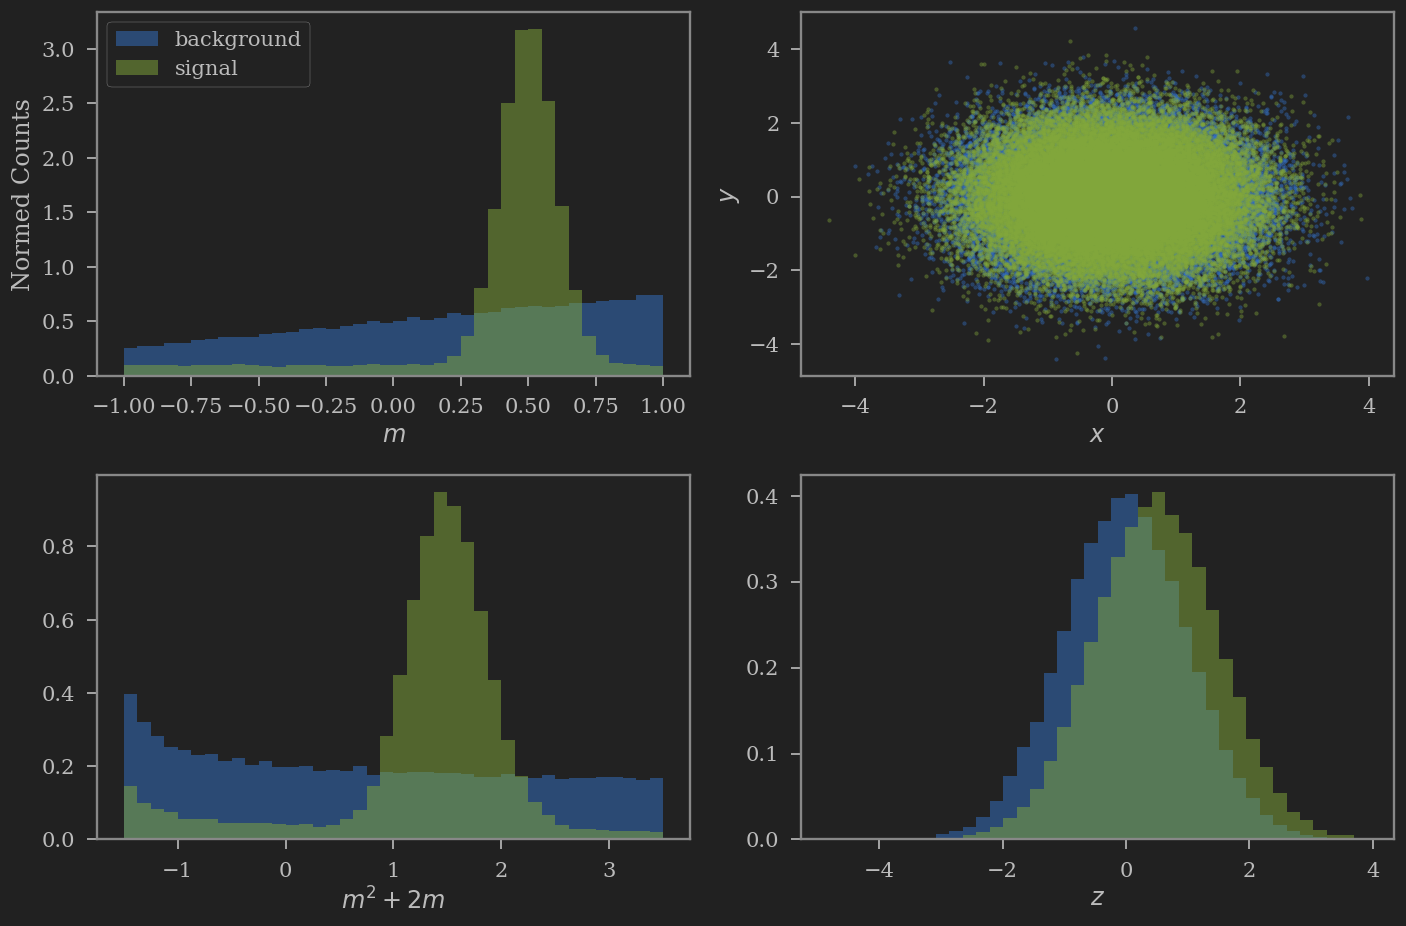

In [7]:
n_s = int(5e4)
n_b = int(5e4)
n_s_gauss_frac = 0.8

a = 1/4 
b = 1/2

u = np.random.uniform(0,1,50000)
u_ = np.random.uniform(0,1,50000)

m_b = - b/(a) + np.sqrt((b-a)**2 + 2*a*u)/(a)
m_s = np.concatenate([np.random.uniform(-1,1,n_s-int(n_s_gauss_frac*n_s)), 
                    np.random.normal(0.5,0.1,size=int(n_s_gauss_frac*n_s))])
m_t = -b/(a) + np.sqrt((b-a)**2 + 2*a*u_)/(a)
m_t.sort()

x_b,y_b  = np.random.multivariate_normal((0,0),[[1,0],[0,1]],size=n_b).T
x_s,y_s  = np.random.multivariate_normal((0,0),[[1,0],[0,1]],size=n_s).T
x_t,y_t  = np.random.multivariate_normal((0,0),[[1,0],[0,1]],size=n_b).T


z_b = np.random.normal(0,1,n_b)
z_s = np.random.normal(0.5,1,n_s)
z_t = np.random.normal(0,1,n_b)

fig ,[[ax1,ax2],[ax3,ax4]] = plt.subplots(2,2,figsize=(12,8),dpi=120)

_,bins,_ = ax1.hist(m_b,bins=40,density=True,alpha=0.5, label='background')
ax1.hist(m_s,bins=bins,density=True,alpha=0.5,label='signal')
ax1.legend()
ax1.set_xlabel(r"$m$")
ax1.set_ylabel("Normed Counts")

ax2.scatter(x_b,y_b,s=5,alpha=0.4)
ax2.scatter(x_s,y_s,s=5,alpha=0.4)
ax2.set_xlabel(r"$x$")
ax2.set_ylabel(r"$y$")

_,bins,_ = ax3.hist(m_b**2+2.5*m_b,bins=40,density=True,alpha=0.5, label='background')
ax3.hist(m_s**2+2.5*m_s,bins=bins,density=True,alpha=0.5,label='signal')
ax3.set_xlabel(r"$m^2 + 2m$")

_,bins,_ = ax4.hist(z_b,bins=40,density=True,alpha=0.5, label='background')
ax4.hist(z_s,bins=bins,density=True,alpha=0.5,label='signal')
ax4.set_xlabel(r"$z$")

#ax2.set_title("Data")
fig.tight_layout()
plt.savefig("./plots/Data.pdf")
plt.show()

In [8]:
x = np.concatenate([np.stack([m_s,m_s**2+2*m_s,x_s,y_s,z_s],axis=1),
                   np.stack([m_b,m_b**2+2*m_b,x_b,y_b,z_b],axis=1)])
    
#x = np.concatenate([m_s,m_b])
y = np.concatenate([np.ones(m_s.size),np.zeros(m_b.size)])

x_test = np.stack([m_t,m_t**2+2*m_t,x_t,y_t,z_t],axis=1) #,x_test,y_test
y_test = np.zeros(n_b)
# Shuffling the data
size = y.size
mask = np.arange(size)
np.random.shuffle(mask)

# Train Validation Split
x_train = x[mask][:int(size*0.8)]
y_train = y[mask][:int(size*0.8)]

x_val = x[mask][int(size*0.8):]
y_val = y[mask][int(size*0.8):]

# Torch Tensors
x_train_tensor = torch.from_numpy(x_train).float().view(-1,5)
y_train_tensor = torch.from_numpy(y_train).float().view(-1,1)
x_val_tensor = torch.from_numpy(x_val).float().view(-1,5)
y_val_tensor = torch.from_numpy(y_val).float().view(-1,1)
x_test_tensor = torch.from_numpy(x_test).float().view(-1,5)
y_test_tensor = torch.from_numpy(y_test).float().view(-1,1)

Epoch:0000/1700 || Train: loss:0.2495, acc:52% || Test: loss: 0.2496, acc:52%
Epoch:0100/1700 || Train: loss:0.2388, acc:59% || Test: loss: 0.2388, acc:60%
Epoch:0200/1700 || Train: loss:0.2288, acc:63% || Test: loss: 0.2289, acc:63%
Epoch:0300/1700 || Train: loss:0.2212, acc:64% || Test: loss: 0.2212, acc:64%
Epoch:0400/1700 || Train: loss:0.2162, acc:66% || Test: loss: 0.2163, acc:65%
Epoch:0500/1700 || Train: loss:0.2124, acc:67% || Test: loss: 0.2125, acc:66%
Epoch:0600/1700 || Train: loss:0.2086, acc:68% || Test: loss: 0.2088, acc:67%
Epoch:0700/1700 || Train: loss:0.2047, acc:69% || Test: loss: 0.2048, acc:68%
Epoch:0800/1700 || Train: loss:0.2005, acc:70% || Test: loss: 0.2007, acc:70%
Epoch:0900/1700 || Train: loss:0.1964, acc:72% || Test: loss: 0.1965, acc:72%
Epoch:1000/1700 || Train: loss:0.1923, acc:73% || Test: loss: 0.1925, acc:73%
Epoch:1100/1700 || Train: loss:0.1883, acc:74% || Test: loss: 0.1885, acc:74%
Epoch:1200/1700 || Train: loss:0.1845, acc:75% || Test: loss: 0.

ValueError: operands could not be broadcast together with shapes (500,100) (50000,) 

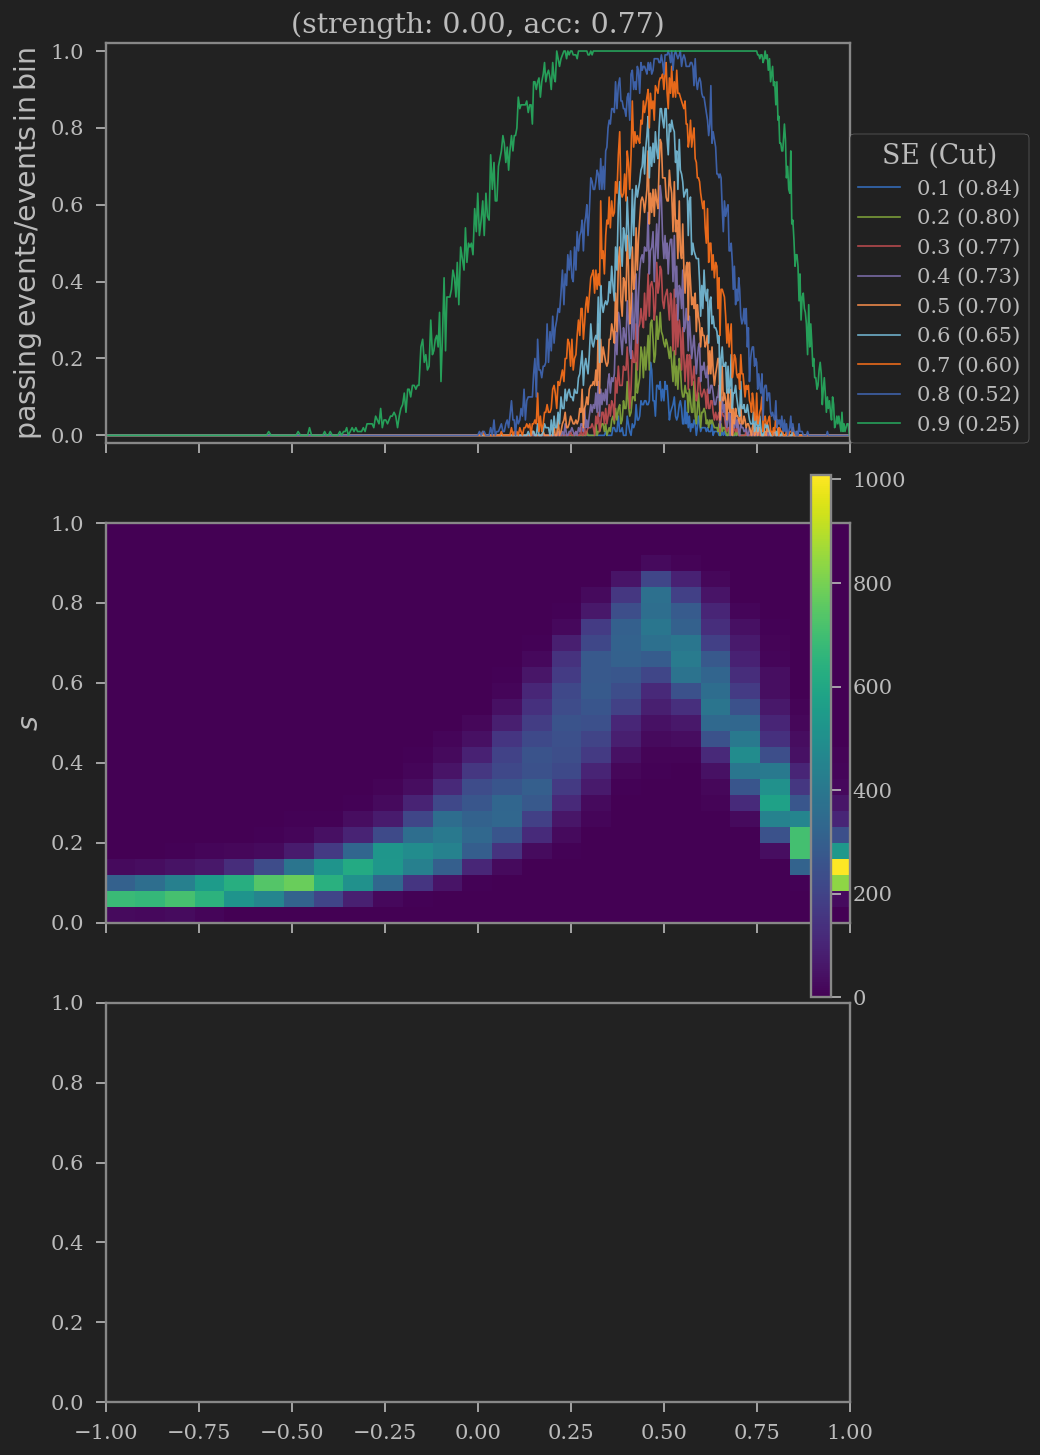

In [9]:
efficiencies = np.linspace(0.1,0.9,9)
for strength in [0,0.5,1,2,3,5,10,15,20]:
    frac = strength/(1+strength)
    metrics_train_legendre = Metrics()
    metrics_val_legendre = Metrics()
    model_legendre = Classifier()
    model_legendre.loss = LegendreLoss(frac=frac,x_biased=x_train[:,0])
    model_legendre.fit(x_train_tensor[:,1:],y_train_tensor,n_epochs=1700,
                       metrics=[metrics_train_legendre,metrics_val_legendre], 
                       val_data=[x_val_tensor[:,1:],y_val_tensor])
    
    validation_predictions = np.array(model_legendre.yhat_val.tolist()).flatten()
    cuts = []
    for eff in efficiencies:
        cuts.append(find_threshold(validation_predictions,(y_val==1),eff))
    
    
    scores = np.array(model_legendre(x_test_tensor[:,1:]).tolist()).reshape(-1,100)
    m = m_t.reshape(-1,100).mean(axis=1)
    Fs = scores.cumsum(axis=1)/scores.sum(axis=1).reshape(-1,1)



    fig, [ax1, ax2, ax3]  = plt.subplots(3,1,figsize=[8,5*3],dpi=120,sharex=True)
    for j,cut in enumerate(cuts):
        c = f"C{j}" if j!= 6 else f"C11"
        passed = (scores>cut).sum(axis=1)/scores.shape[1]
        ax1.plot(m,passed,label="{:0.1f} ({:0.2f})".format(efficiencies[j],cut),alpha=0.9,c=c,lw=1)

        #plt.plot(m,legendre[:,i*10],label="fit",ls='--')
    #plt.scatter(x_train[:,0],jiang_scores,label="Jiang Response",c='w',alpha=0.5,s=1)
    ax1.set_ylabel(r"$\mathrm{passing\, events}/\mathrm{events\,in\, bin}$",fontsize=17)
    ax1.set_ylim([-0.02,1.02])
    ax1.set_title("(strength: {:.02f}, acc: {:.02})".format(strength, metrics_val_legendre.accs[-1]),fontsize=17)
    ax1.legend(loc=(1,0),markerscale=5,title="SE (Cut)",ncol=1)

    _,_,_,h = ax2.hist2d(m_t,scores.flatten(),bins=25, label="all",cmap='viridis',range=[[-1,1],[0,1]])#norm=LogNorm())
    cbaxes = fig.add_axes([0.86, 0.35, 0.02, 0.29]) 
    plt.colorbar(h,ax=ax2,cax = cbaxes)
    ax2.set_ylabel(r"$s$",fontsize=17)
    
    
    _,_,_,h = ax3.hist2d(m_t.reshape(-1,100),Fs.flatten(),bins=20, label="all")#norm=LogNorm())
    ax3.set_ylabel(r"$F(s)$",fontsize=17)
    cbaxes = fig.add_axes([0.86, 0.05, 0.02, 0.29]) 
    plt.colorbar(h,ax=ax3,cax = cbaxes)
    ax3.set_xlabel(r"$m$",fontsize=19)



    fig.tight_layout(pad=0)
    plt.show()